<span style="font-size: 210%;color:white;background:black"> Walidacja modeli [Stroke_Prediction.csv]

### <span style="color:blue"> Cognition comes by comparison! Friedrich Wilhelm Nietzsche
    
Modele cross-validated mogą być zgrane z dysku - jakość zgranych modeli zależy między innymi od wielkości próby na jakiej zostały przeszkolone. Jeżeli wgramy model szkolony na próbie 0.05 to gdy po zgraniu tych modeli z dysku ustawimy 0.05 populacji to otrzymamy identyczne wyniki na wskaźnikach. Czyli nagranie trzyma wyuczenie modeli. Natomiast można modele wyszkolić na próbie 0.5 a nastepnie wgrać i uruchomić na próbie 100%.     
 
## <span style="font-size: 100%;color:#6fa8dc;background:#cfe2f3">Ważne wnioski!!

## <span style="font-size: 100%;color:#6fa8dc;background:#cfe2f3">Modele cross-validated wyćwiczony na małej próbie z beznadziejnymi odczytami i parametrami, uruchomiony na pełnej próbie 100% zachowuje się znacznie lepiej. Dodatkowo zgranie wzbagowanych wersji słabych modeli cross-validated z małej próby daje bardzo dobre rezultaty jeżeli chodzi o poprawę parametrów na wielkiej próbie 100%.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import BaggingClassifier
from simple_colors import *
from prettytable import PrettyTable
import time
import joblib

warnings.filterwarnings("ignore")

%matplotlib inline

df = pd.read_csv('/media/wojciech/D6DE33C1DE339927/1A/Stroke_Prediction.csv')
print(df.shape)
print()
print(df.columns)
df.head(3)

(43400, 12)

Index(['ID', 'Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')


,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


## <div class="alert-success"> Cudowna formuła poprawiająca nazwy kolumn

In [2]:
import re
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

## <div class="alert-success"> Sample reduction:</div>

In [3]:
df = df.sample(frac=0.5, random_state=10)
df.shape

(21700, 12)

#### Start pomiaru czasu

In [4]:
import time
start_time = time.time()  # pomiar czasu: start pomiaru czasu
print(time.ctime())

Mon Nov 16 21:39:34 2020


### Tool for automatic coding of discrete variables !


In [5]:
a, b = df.shape  # <- ile mamy kolumn
b

print('DISCRETE FUNCTIONS CODED')
print('------------------------')
for i in range(1, b):
    i = df.columns[i]
    f = df[i].dtypes
    if f == np.object:
        print(i, "---", f)

        if f == np.object:

            df[i] = pd.Categorical(df[i]).codes

            continue

DISCRETE FUNCTIONS CODED
------------------------
Gender --- object
Ever_Married --- object
Type_Of_Work --- object
Residence --- object
Smoking_Status --- object


In [6]:
df.fillna(7777, inplace=True)

## <div class="alert-success"> Ręczne ustawienie celu

In [7]:
target = 'Stroke'

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123, stratify=y)

# <span style="font-size: 100%;color:#6fa8dc;background:#cfe2f3">Oversampling   !! 

In [9]:
def oversampling(ytrain, Xtrain):
    import matplotlib.pyplot as plt

    global Xtrain_OV
    global ytrain_OV

    calss1 = np.round(
        (sum(ytrain == 1)/(sum(ytrain == 0)+sum(ytrain == 1))), decimals=2)*100
    calss0 = np.round(
        (sum(ytrain == 0)/(sum(ytrain == 0)+sum(ytrain == 1))), decimals=2)*100

    print("y = 0: ", sum(ytrain == 0), '-------', calss0, '%')
    print("y = 1: ", sum(ytrain == 1), '-------', calss1, '%')
    print('--------------------------------------------------------')

    ytrain.value_counts(dropna=False, normalize=True).plot(
        kind='pie', title='Before oversampling')
    plt.show
    print()

    Proporcja = sum(ytrain == 0) / sum(ytrain == 1)
    Proporcja = np.round(Proporcja, decimals=0)
    Proporcja = Proporcja.astype(int)

    ytrain_OV = pd.concat([ytrain[ytrain == 1]] * Proporcja, axis=0)
    Xtrain_OV = pd.concat([Xtrain.loc[ytrain == 1, :]] * Proporcja, axis=0)

    ytrain_OV = pd.concat([ytrain, ytrain_OV], axis=0).reset_index(drop=True)
    Xtrain_OV = pd.concat([Xtrain, Xtrain_OV], axis=0).reset_index(drop=True)

    Xtrain_OV = pd.DataFrame(Xtrain_OV)
    ytrain_OV = pd.DataFrame(ytrain_OV)

    print("Before oversampling Xtrain:     ", Xtrain.shape)
    print("Before oversampling ytrain:     ", ytrain.shape)
    print('--------------------------------------------------------')
    print("After oversampling Xtrain_OV:  ", Xtrain_OV.shape)
    print("After oversampling ytrain_OV:  ", ytrain_OV.shape)
    print('--------------------------------------------------------')

    ax = plt.subplot(1, 2, 1)
    ytrain.value_counts(dropna=False, normalize=True).plot(
        kind='pie', title='Before oversampling')
    plt.show

    kot = pd.concat([ytrain[ytrain == 1]] * Proporcja, axis=0)
    kot = pd.concat([ytrain, kot], axis=0).reset_index(drop=True)
    ax = plt.subplot(1, 2, 2)
    kot.value_counts(dropna=False, normalize=True).plot(
        kind='pie', title='After oversampling')
    plt.show

y = 0:  17040 ------- 98.0 %
y = 1:  320 ------- 2.0 %
--------------------------------------------------------

Before oversampling Xtrain:      (17360, 11)
Before oversampling ytrain:      (17360,)
--------------------------------------------------------
After oversampling Xtrain_OV:   (34320, 11)
After oversampling ytrain_OV:   (34320, 1)
--------------------------------------------------------


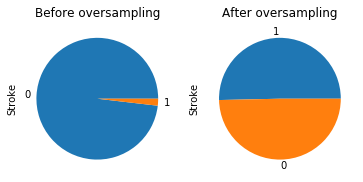

In [10]:
oversampling(y_train, X_train)

I used six models of GaussianNB, LogisticRegression, CatBoostClassifier in their basic version without oversamplin and with oversampling. We will see what differences in the minority set classification the oversampling method gives.!!

I get rid of one dimension from the ytrain_OV set so that the set is similar to y_test.

In [11]:
print(Xtrain_OV.shape)
print(ytrain_OV.shape)
ytrain_OV = ytrain_OV[target]
print(ytrain_OV.shape)

(34320, 11)
(34320, 1)
(34320,)


W poprzednim wpisie uznaliśmy, że oversampling poprawiło jakość klasyfikacji. Kolejne działania będą opierały sie na danych zbilansowanych przez oversampling. Dlatego teraz podmieniamy zwykłą próbę na próbę po oversamoling.

In [12]:
X_train = Xtrain_OV
y_train = ytrain_OV
print(X_train.shape)
print(y_train.shape)

(34320, 11)
(34320,)


In [13]:
Data = Xtrain_OV
target = ytrain_OV
print("output:", Data.shape)
print("output:", target.shape)
print('----------')
print("input:", df.shape)

output: (34320, 11)
output: (34320,)
----------
input: (21700, 12)


In [14]:
X_train.shape

(34320, 11)

In [15]:
print('1', y_train[y_train==1].shape)
print('0', y_train[y_train==0].shape)

1 (17280,)
0 (17040,)


## <div class="alert-success"> Sterowanie zakresu waluacji

In [16]:
Model1 = 1
Model2 = 1
Model3 = 1
Model4 = 1

### <span style="font-size: 110%;color:white;background:Red">Model 1 <span style="font-size: 110%;color:#6fa8dc;background:#cfe2f3">  Modele na ustawieniach fabrycznych


In [17]:
if Model1 < 1 :
    pass
else:
    
    SVM = joblib.load('/home/wojciech/Pulpit/7/model1-SVM.pkl')
    CBC = joblib.load('/home/wojciech/Pulpit/7/model1-CBC.pkl')
    XGB = joblib.load('/home/wojciech/Pulpit/7/model1-XGB.pkl')
    LGBM = joblib.load('/home/wojciech/Pulpit/7/model1-LGBM.pkl')
    KNN = joblib.load('/home/wojciech/Pulpit/7/model1-KNN.pkl')
    NBC = joblib.load('/home/wojciech/Pulpit/7/model1-NBC.pkl')
    LRE = joblib.load('/home/wojciech/Pulpit/7/model1-LRE.pkl')
    RFC = joblib.load('/home/wojciech/Pulpit/7/model1-RFC.pkl')
    GBC = joblib.load('/home/wojciech/Pulpit/7/model1-GBC.pkl')

classifiers_1 = [SVM,CBC,XGB,LGBM,KNN,NBC,LRE,RFC,GBC]
name1 = ['SVM','CBC','XGB','LGBM','KNN','NBC','LRE','RFC','GBC']

### <span style="font-size: 110%;color:white;background:Red">Model 2  <span style="font-size: 110%;color:#6fa8dc;background:#cfe2f3">  Modele na ustawieniach fabrycznych po bagging 


In [18]:
if Model2 < 1:
    pass
else:
    
    SVM_b = joblib.load('/home/wojciech/Pulpit/7/model2-SVM_b.pkl')
    CBC_b = joblib.load('/home/wojciech/Pulpit/7/model2-CBC_b.pkl')
    XGB_b = joblib.load('/home/wojciech/Pulpit/7/model2-XGB_b.pkl')
    LGBM_b = joblib.load('/home/wojciech/Pulpit/7/model2-LGBM_b.pkl')
    KNN_b = joblib.load('/home/wojciech/Pulpit/7/model2-KNN_b.pkl')
    NBC_b = joblib.load('/home/wojciech/Pulpit/7/model2-NBC_b.pkl')
    LRE_b = joblib.load('/home/wojciech/Pulpit/7/model2-LRE_b.pkl')
    RFC_b = joblib.load('/home/wojciech/Pulpit/7/model2-RFC_b.pkl')
    GBC_b = joblib.load('/home/wojciech/Pulpit/7/model2-GBC_b.pkl')

    classifiers_2 = [SVM_b,CBC_b,XGB_b,LGBM_b,KNN_b,NBC_b,LRE_b,RFC_b,GBC_b]
    name2 = ['SVM_b','CBC_b','XGB_b','LGBM_b','KNN_b','NBC_b','LRE_b','RFC_b','GBC_b']

### <span style="font-size: 110%;color:white;background:Red">Model 3  <span style="font-size: 110%;color:#6fa8dc;background:#cfe2f3">  Modele na ustawieniach fabrycznych po kalibracji

In [19]:
if Model3 < 1:
    pass
else:

    SVM3 = joblib.load('/home/wojciech/Pulpit/7/model3-SVM_c.pkl')
    CBC3 = joblib.load('/home/wojciech/Pulpit/7/model3-CBC_c.pkl')
    XGB3 = joblib.load('/home/wojciech/Pulpit/7/model3-XGB_c.pkl')
    LGBM3 = joblib.load('/home/wojciech/Pulpit/7/model3-LGBM_c.pkl')
    KNN3 = joblib.load('/home/wojciech/Pulpit/7/model3-KNN_c.pkl')
    NBC3 = joblib.load('/home/wojciech/Pulpit/7/model3-NBC_c.pkl')
    LRE3 = joblib.load('/home/wojciech/Pulpit/7/model3-LRE_c.pkl')
    RFC3 = joblib.load('/home/wojciech/Pulpit/7/model3-RFC_c.pkl')
    GBC3 = joblib.load('/home/wojciech/Pulpit/7/model3-GBC_c.pkl')

    classifiers_3 = [SVM3,CBC3,XGB3,LGBM3,KNN3,NBC3,LRE3,RFC3,GBC3]
    name3 = ['SVM3','CBC3','XGB3','LGBM3','KNN3','NBC3','LRE3','RFC3','GBC3']

### <span style="font-size: 110%;color:white;background:Red">Model 4  <span style="font-size: 110%;color:#6fa8dc;background:#cfe2f3">  Modele na ustawieniach fabrycznych po bagging i po kalibracji

In [20]:
if Model4 < 1:
    pass
else:

    SVM_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-SVM_d.pkl')
    CBC_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-CBC_d.pkl')
    XGB_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-XGB_d.pkl')
    LGBM_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-LGBM_d.pkl')
    KNN_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-KNN_d.pkl')
    NBC_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-NBC_d.pkl')
    LRE_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-LRE_d.pkl')
    RFC_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-RFC_d.pkl')
    GBC_b4 = joblib.load('/home/wojciech/Pulpit/7/model4-GBC_d.pkl')

    classifiers_4 = [SVM_b4,CBC_b4,XGB_b4,LGBM_b4,KNN_b4,NBC_b4,LRE_b4,RFC_b4,GBC_b4]
    name4 = ['SVM_b4','CBC_b4','XGB_b4','LGBM_b4','KNN_b4','NBC_b4','LRE_b4','RFC_b4','GBC_b4']

### Gdzie zapisywane będą modele

In [21]:
# <=  modele na ustawieniach fabrycznych
csv1 = '/home/wojciech/Pulpit/7/model1.csv'
# <=  modele na ustawieniach fabrycznych po bagging
csv2 = '/home/wojciech/Pulpit/7/model2.csv'
# <=  modele na ustawieniach fabrycznych po kalibracji
csv3 = '/home/wojciech/Pulpit/7/model3.csv'
# <=  modele na ustawieniach fabrycznych po bagging po kalibracji
csv4 = '/home/wojciech/Pulpit/7/model4.csv'

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3"> Najważnieszy dla mnie zbiór wskaźników Type_error

#### <span style="color:blue">False_Positive_Rate - procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych

#### <span style="color:blue">True_Positive_Rate RECALL - wskaźnik ten pokazuje jaka jest wykrywalność choroby przez model.

In [22]:
def df_valuator(classifiers, names, y_test, X_test, adres):

    def obliczenieX(model, names, y_test, X_test):

        global dfv

        from sklearn.metrics import confusion_matrix

        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()

        FPR = np.round(fp/(fp + tn), decimals=3)
        TPR = np.round(tp/(tp + fn), decimals=3)
        FNR = np.round(fn/(tp + fn), decimals=3)
        SPEC = np.round(tn/(tn + fp), decimals=3)

        dfv = pd.DataFrame({'model': names, 'FPR': [FPR], 'TPR': [
                           TPR], 'FNR': [FNR], 'SPEC': [SPEC]})
        return dfv

# -------------------------------------------
    start_time = time.time()

    appended_data = []
    for t, n in zip(classifiers, names):
        results = obliczenieX(t, n, y_test, X_test)
        appended_data.append(results)
    appended_data = pd.concat(appended_data)
    filename = adres  # .format(n)
    appended_data.to_csv(filename)

    p = np.round((time.time() - start_time), decimals=1)
    print(blue(adres), p, "---", time.ctime())

In [23]:
 Valuator = [] 

if Model1 < 1:
    pass
else:    
    df_valuator(classifiers_1 ,name1, y_test,X_test,csv1)
    df_1 = pd.read_csv('/home/wojciech/Pulpit/7/model1.csv')
    df_1['comment'] = 'Modele na ustawieniach fabrycznych'
    Valuator = pd.concat([df_1], sort=True).sort_values(['FPR','TPR'],ascending=[True,False]) 
    
if Model2 < 1:
    pass
else:        
    df_valuator(classifiers_2 ,name2, y_test,X_test,csv2)
    df_2 = pd.read_csv('/home/wojciech/Pulpit/7/model2.csv')
    df_2['comment'] = 'Modele na ustawieniach fabrycznych po bagging'
    Valuator = pd.concat([df_1,df_2], sort=True).sort_values(['FPR','TPR'],ascending=[True,False]) 
    
if Model3 < 1:
    pass
else:    
    df_valuator(classifiers_3 ,name3, y_test,X_test,csv3)
    df_3 = pd.read_csv('/home/wojciech/Pulpit/7/model3.csv')
    df_3['comment'] = 'Modele na ustawieniach fabrycznych po kalibracji'
    Valuator = pd.concat([df_1,df_2,df_3], sort=True).sort_values(['FPR','TPR'],ascending=[True,False]) 
    
    
if Model4 < 1:
    pass
else:    
    df_valuator(classifiers_4 ,name4, y_test,X_test,csv4)
    df_4 = pd.read_csv('/home/wojciech/Pulpit/7/model4.csv')
    df_4['comment'] = 'Modele na ustawieniach fabrycznych po bagging po kalibracji'
    Valuator = pd.concat([df_1,df_2,df_3,df_4], sort=True).sort_values(['FPR','TPR'],ascending=[True,False]) 
    

/home/wojciech/Pulpit/7/model1.csv 0.8 --- Mon Nov 16 21:39:41 2020
/home/wojciech/Pulpit/7/model2.csv 3.5 --- Mon Nov 16 21:39:45 2020
/home/wojciech/Pulpit/7/model3.csv 2.4 --- Mon Nov 16 21:39:47 2020
/home/wojciech/Pulpit/7/model4.csv 9.5 --- Mon Nov 16 21:39:57 2020


In [24]:
del Valuator['Unnamed: 0']

In [25]:
from simple_colors import *

print(red('False_Positive_Rate','bold'),red('procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych','italic'))
print(red('True_Positive_Rate RECALL','bold'), red('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi chorych ogółem','italic'))
print(black('False_Negative_Rate','bold'), black('procentowy udział niewykrytych chorych w populacji ludzi chorych ogółem','italic'))
print(black('Specifity','bold'), black('procentowy udział ludzi zdrowych uznanych za zdrowych w populacji ludzi zdrowych','italic'))
#Valuator[['model','comment','TPR','FPR']]
best = Valuator[(Valuator.TPR>0.55) &(Valuator.FPR<0.40)]
best[['model','comment','TPR','FPR']]

False_Positive_Rate procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych
True_Positive_Rate RECALL procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi chorych ogółem
False_Negative_Rate procentowy udział niewykrytych chorych w populacji ludzi chorych ogółem
Specifity procentowy udział ludzi zdrowych uznanych za zdrowych w populacji ludzi zdrowych


,model,comment,TPR,FPR
5,NBC_b,Modele na ustawieniach fabrycznych po bagging,0.700,0.161
5,NBC,Modele na ustawieniach fabrycznych,0.750,0.173
5,NBC3,Modele na ustawieniach fabrycznych po kalibracji,0.762,0.196
5,NBC_b4,Modele na ustawieniach fabrycznych po bagging ...,0.762,0.198
0,SVM_b4,Modele na ustawieniach fabrycznych po bagging ...,0.750,0.221
0,SVM3,Modele na ustawieniach fabrycznych po kalibracji,0.762,0.228
0,SVM,Modele na ustawieniach fabrycznych,0.762,0.231
0,SVM_b,Modele na ustawieniach fabrycznych po bagging,0.750,0.242
6,LRE_b4,Modele na ustawieniach fabrycznych po bagging ...,0.750,0.278
6,LRE3,Modele na ustawieniach fabrycznych po kalibracji,0.675,0.285


In [26]:
best['model'].head(9).to_list()

['NBC_b', 'NBC', 'NBC3', 'NBC_b4', 'SVM_b4', 'SVM3', 'SVM', 'SVM_b', 'LRE_b4']

## <div class="alert-danger"> Wybieramy manualnie modele do walidacji - musi być 9 modeli!

In [27]:
clasifier_VAL = [NBC_b, NBC, NBC3, NBC_b4, SVM_b4, SVM3, SVM, SVM_b, LRE_b4]
name_VAL = ['NBC_b', 'NBC', 'NBC3', 'NBC_b4', 'SVM_b4', 'SVM3', 'SVM', 'SVM_b', 'LRE_b4']

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Models Valuation

In [28]:
def Type_error(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    
    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn.metrics import confusion_matrix
    
    from sklearn import metrics
    import simple_colors
    import time   
    
    start_time = time.time()
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    FPR = ['False_Positive_Rate:']
    TPR = ['True_Positive_Rate: ']
    FNR = ['False_Negative_Rate: ']
    SPEC = ['Specifity']
    
    CAL_FPR = ['CAL_False_Positive_Rate:']
    CAL_TPR = ['CAL_True_Positive_Rate: ']
    CAL_FNR = ['CAL_False_Negative_Rate: ']
    CAL_SPEC = ['CAL_Specifity']

    def compute_metric(model):
        
        
        
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()
        # print('tn: ',tn)
        # print('fp: ',fp)
        # print('fn: ',fn)
        # print('tp: ',tp)
        # print('------------------')
        # print(cm) 
        

        FPR = np.round(fp/(fp + tn),decimals=3)
        TPR = np.round(tp/(tp + fn),decimals=3)
        FNR = np.round(fn/(tp + fn),decimals=3)
        SPEC = np.round(tn/(tn + fp),decimals=3)

        return FPR,TPR,FNR,SPEC

    for cls in six_classifiers:      
        
        results = compute_metric(cls)
        FPR.append(red(results[0],'bold'))
        TPR.append(red(results[1],'bold'))
        FNR.append(results[2])
        SPEC.append(results[3])

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(FPR)
    t.add_row(TPR)
    t.add_row(FNR)
    t.add_row(SPEC)

    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
  ## --------------------------------------------------  
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
  
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
        
            ck = confusion_matrix(y_test, calibrated.predict(X_test))
            tn_c, fp_c, fn_c, tp_c = ck.ravel()
            # print('tn: ',tn)
            # print('fp: ',fp)
            # print('fn: ',fn)
            # print('tp: ',tp)
            # print('------------------')
            # print(cm) 
        

            CAL_FPR = np.round(fp_c/(fp_c + tn_c),decimals=3)
            CAL_TPR = np.round(tp_c/(tp_c + fn_c),decimals=3)
            CAL_FNR = np.round(fn_c/(tp_c + fn_c),decimals=3)
            CAL_SPEC = np.round(tn_c/(tn_c + fp_c),decimals=3)

            return CAL_FPR, CAL_TPR, CAL_FNR, CAL_SPEC

        for cls in six_classifiers:      
        
            results = calibration(cls)
            CAL_FPR.append(red(results[0],'bold'))
            CAL_TPR.append(red(results[1],'bold'))
            CAL_FNR.append(results[2])
            CAL_SPEC.append(results[3])

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_FPR)
        k.add_row(CAL_TPR)
        k.add_row(CAL_FNR)
        k.add_row(CAL_SPEC)
    
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    
    
    print(red('False_Positive_Rate','bold'),red('procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych','italic'))
    print(red('True_Positive_Rate RECALL','bold'), red('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi chorych ogółem','italic'))
    print(black('False_Negative_Rate','bold'), black('procentowy udział niewykrytych chorych w populacji ludzi chorych ogółem','italic'))
    print(black('Specifity','bold'), black('procentowy udział ludzi zdrowych uznanych za zdrowych w populacji ludzi zdrowych','italic'))

In [29]:
Type_error(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 11.0 seconds
+-----------------------+-------+-------+-------+--------+--------+-------+-------+-------+--------+
|          Name         | NBC_b |  NBC  |  NBC3 | NBC_b4 | SVM_b4 |  SVM3 |  SVM  | SVM_b | LRE_b4 |
+-----------------------+-------+-------+-------+--------+--------+-------+-------+-------+--------+
|  False_Positive_Rate: | 0.161 | 0.173 | 0.196 | 0.198  | 0.221  | 0.228 | 0.231 | 0.242 | 0.278  |
|  True_Positive_Rate:  |  0.7  |  0.75 | 0.762 | 0.762  |  0.75  | 0.762 | 0.762 |  0.75 |  0.75  |
| False_Negative_Rate:  |  0.3  |  0.25 | 0.238 | 0.238  |  0.25  | 0.238 | 0.238 |  0.25 |  0.25  |
|       Specifity       | 0.839 | 0.827 | 0.804 | 0.802  | 0.779  | 0.772 | 0.769 | 0.758 | 0.722  |
+-----------------------+-------+-------+-------+--------+--------+-------+-------+-------+--------+

False_Positive_Rate procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych
True_Positive_Rate RECALL procento

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Binary Classficators Plots  

In [30]:
def BinaryClassPlot(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    import time
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    start_time = time.time()
    
    from plot_metric.functions import BinaryClassification

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train) 
       
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
        
    for i in range(9):
        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')
            
        model = six_classifiers[i]
        bc = BinaryClassification(y_test, model.predict_proba(X_test)[:,1], labels=["Class 1", "Class 2"])
        bc.plot_roc_curve(title=type(six_classifiers[i]).__name__)
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10) 
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł

 ### ------------------------------------------------------------------------------       
    if calibration != True:
        print()
    else:    
           
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)
                            
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

        for i in range(9):
            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')
            
            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)        
                
            bc = BinaryClassification(y_test, calibrated.predict_proba(X_test)[:,1], labels=["Class 1", "Class 2"])
            bc.plot_roc_curve(title=type(six_classifiers[i]).__name__)
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł     
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł   
        
        
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)    

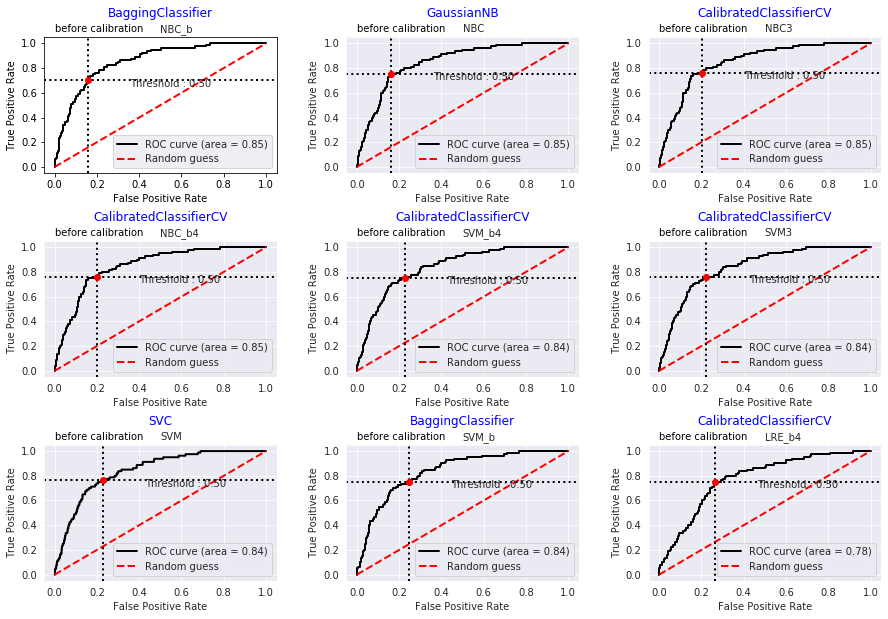

In [31]:
BinaryClassPlot(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3"> ROC AUC plots

In [32]:
def plot_roc(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    import time
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    import scikitplot as skplt
    
    start_time = time.time()
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]
        skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10)
## ---------------------------------------------------------------------------------------------------
    
    if calibration != True:
        print()
    else:    
    
    
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
    
    
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)

        for i in range(9):

            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')

            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)        
        
            skplt.metrics.plot_roc(y_test, calibrated.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł  
    
    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)    

In [ ]:
plot_roc(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

W tym teście szczególnie waża jest różnica pomiedzy <span style="background:#ff00ff"> krzywą micro-average ROC pokazaną na różowo</span> oraz <span style="color:#0000ff"> krzywą macro-average ROC pokazana na granatowo</span>.
Idealnie gdy obie krzywe się pokrywają. Zbilansowanie klas prze oversampling poprawiło w wielu medelach spójność obu krzywych, w niektórych jednak pozostały duże różnice.

Jeżeli: 

<span style="font-size: 150%;color:#0000ff">macro average ROC</span><span style="font-size: 250%"> > </span> <span style="font-size: 150%;background:#ff00ff">micro average ROC</span> 
wtedy mówimy, że: "1 (minority) is better classified than 0 (majority) - macro > micro"

Jeżeli:

<span style="font-size: 150%;color:#0000ff">macro average ROC</span><span style="font-size: 250%"> < </span> <span style="font-size: 150%;background:#ff00ff">micro average ROC</span> 
wtedy mówimy, że: '0 (majority) is better classified than 1 (minority)- micro < macro'


Idealnie gdy krzywe micro i macro pokrywają się ze sobą. Taka sytuacja ma miejsce po oversampling w GaussianNB oraz GradientBoostingClassifier.


## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Confusion matrix

In [ ]:
def confusion_matrix(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 20 
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve 
    from sklearn.metrics import plot_confusion_matrix
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train) 
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
    target_names = ['0','1']


    for t,cls, ax in zip(name, six_classifiers, axes.flatten()):
        plot_confusion_matrix(cls, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues',
                             display_labels=target_names,values_format='')
        ax.title.set_text(type(cls).__name__)
        ax.title.set_color('blue')
        ax.text(-0.5, -0.56, t,fontsize=12)
        ax.text(-0.5, 1.40, 'before calibration',color='black', fontsize=10) 
        
    plt.tight_layout()  
    plt.show()
    
### ---------------------------------------------------
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))

    ### ---------------------------------------------------
    
    
        for cls in six_classifiers:
            calibrated = CalibratedClassifierCV(cls, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
    
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
        target_names = ['0','1']


        for t,cls, ax in zip(name, six_classifiers, axes.flatten()):
            plot_confusion_matrix(cls, 
                                  X_test, 
                                  y_test, 
                                  ax=ax, 
                                  cmap='Blues',
                                 display_labels=target_names,values_format='')
            ax.title.set_text(type(cls).__name__)
            ax.title.set_color('blue')
            ax.text(-0.5, -0.56, t,fontsize=12)
            ax.text(-0.5, 1.40, 'after calibration',color='red', fontsize=10)    ## podtytuł     


In [ ]:
confusion_matrix(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Recall - Precision!

In [ ]:
def Recall_Precision(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve  
    
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
    from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report
    from sklearn.metrics import accuracy_score
    from mlxtend.plotting import plot_learning_curves
    from prettytable import PrettyTable
    import time   
    
    start_time = time.time()
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)
      
    
    Recall_Training = ['Recall Training: ']
    Precision_Training = ['Precision Training: ']
    Recall_Test= ['Recall Test: ']
    Precision_Test = ['Precision Test: ']
    
    CAL_Recall_Training = ['CAL_Recall Training: ']
    CAL_Precision_Training = ['CAL_Precision Training: ']
    CAL_Recall_Test= ['CAL_Recall Test: ']
    CAL_Precision_Test = ['CAL_Precision Test: ']   

    def compute_metric2(model):

        Recall_Training = np.round(recall_score(y_train, model.predict(X_train)), decimals=3)
        Precision_Training = np.round(precision_score(y_train, model.predict(X_train)), decimals=3)
        Recall_Test = np.round(recall_score(y_test, model.predict(X_test)), decimals=3) 
        Precision_Test = np.round(precision_score(y_test, model.predict(X_test)), decimals=3)
        
        return Recall_Training, Precision_Training, Recall_Test, Precision_Test
    
    for cls in six_classifiers:

        results = compute_metric2(cls)
        Recall_Training.append(results[0])
        Precision_Training.append(results[1])
        Recall_Test.append(blue(results[2],'bold'))
        Precision_Test.append((blue(results[3],'bold')))
   
    
    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(Recall_Training)
    t.add_row(Precision_Training)
    t.add_row(Recall_Test)
    t.add_row(Precision_Test)

    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
  ### ---------------------------------------------------------  
    
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))

            
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
       
            
        
            CAL_Recall_Training = np.round(recall_score(y_train, calibrated.predict(X_train)), decimals=3)
            CAL_Precision_Training = np.round(precision_score(y_train, calibrated.predict(X_train)), decimals=3)
            CAL_Recall_Test = np.round(recall_score(y_test, calibrated.predict(X_test)), decimals=3) 
            CAL_Precision_Test = np.round(precision_score(y_test, calibrated.predict(X_test)), decimals=3)
        
            return CAL_Recall_Training, CAL_Precision_Training, CAL_Recall_Test, CAL_Precision_Test 
    
        start_time = time.time()
    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_Recall_Training.append(results[0])
            CAL_Precision_Training.append(results[1])
            CAL_Recall_Test.append(blue(results[2],'bold'))
            CAL_Precision_Test.append((blue(results[3],'bold')))
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_Recall_Training)
        k.add_row(CAL_Precision_Training)
        k.add_row(CAL_Recall_Test)
        k.add_row(CAL_Precision_Test)   
    
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    print(blue('Wskaźniki pokazują RECALL i PRECISION dla klasy 1','bold'))
    print(blue('RECALL', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych','italic'))
    print(blue('PRECISION', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi zdiagnozowanych fałszywie (zdrowych uznanych przez model za chorych) i dobrze zdiagnozowanych (chorych uznanych przez model za chorych)','italic'))

In [ ]:
Recall_Precision(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Classification score

In [ ]:
def classification_score(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve   
    from sklearn.metrics import precision_recall_fscore_support as score
    import time   
    
    start_time = time.time()

    Precision_0 = ['Precision_0: ']
    Precision_1 = ['Precision_1: ']
    Recall_0 = ['Recall_0: ']
    Recall_1 = ['Recall_1: ']
    f1_score_0 = ['f1-score_0: ']
    f1_score_1 = ['f1-score_1: ']
    Support_0 = ['Support_0: ']
    Support_1 = ['Support_1: ']
    
    
    CAL_Precision_0 = ['CAL_Precision_0: ']
    CAL_Precision_1 = ['CAL_Precision_1: ']
    CAL_Recall_0 = ['CAL_Recall_0: ']
    CAL_Recall_1 = ['CAL_Recall_1: ']
    CAL_f1_score_0 = ['CAL_f1-score_0: ']
    CAL_f1_score_1 = ['CAL_f1-score_1: ']
    CAL_Support_0 = ['CAL_Support_0: ']
    CAL_Support_1 = ['CAL_Support_1: ']

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)
        
    
    def compute_metric4(model):

        precision, recall, fscore, support = score(y_test, model.predict(X_test))
    
        Precision_0 = np.round(precision[:1],decimals=3).item()
        Precision_1 = np.round(precision[1:],decimals=3).item()
        Recall_0 = np.round(recall[:1],decimals=3).item()
        Recall_1 = np.round(recall[1:],decimals=3).item()
        f1_score_0 = np.round(fscore[:1],decimals=3).item()
        f1_score_1 = np.round(fscore[1:],decimals=3).item()
        Support_0 = np.round(support[:1],decimals=3).item()
        Support_1 = np.round(support[1:],decimals=3).item()
        
        return Precision_0, Precision_1, Recall_0, Recall_1, f1_score_0, f1_score_1, Support_0, Support_1

    for cls in six_classifiers:

        results = compute_metric4(cls)
        Precision_0.append(results[0])
        Precision_1.append(blue(results[1],'bold'))
        Recall_0.append(results[2])
        Recall_1.append(blue(results[3],'bold'))
        f1_score_0.append(results[4])
        f1_score_1.append(blue(results[5],'bold'))
        Support_0.append(results[6])
        Support_1.append(blue(results[7],'bold'))
         

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(Precision_0)
    t.add_row(Precision_1)
    t.add_row(Recall_0)
    t.add_row(Recall_1)
    t.add_row(f1_score_0)
    t.add_row(f1_score_1)
    t.add_row(Support_0)
    t.add_row(Support_1)


    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
   ## ------------------------------------------

    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
  
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
            precision, recall, fscore, support = score(y_test, calibrated.predict(X_test))
                
            CAL_Precision_0 = np.round(precision[:1],decimals=3).item()
            CAL_Precision_1 = np.round(precision[1:],decimals=3).item()
            CAL_Recall_0 = np.round(recall[:1],decimals=3).item()
            CAL_Recall_1 = np.round(recall[1:],decimals=3).item()
            CAL_f1_score_0 = np.round(fscore[:1],decimals=3).item()
            CAL_f1_score_1 = np.round(fscore[1:],decimals=3).item()
            CAL_Support_0 = np.round(support[:1],decimals=3).item()
            CAL_Support_1 = np.round(support[1:],decimals=3).item()
        
            return CAL_Precision_0, CAL_Precision_1, CAL_Recall_0, CAL_Recall_1, CAL_f1_score_0, CAL_f1_score_1, CAL_Support_0, CAL_Support_1
    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_Precision_0.append(results[0])
            CAL_Precision_1.append(blue(results[1],'bold'))
            CAL_Recall_0.append(results[2])
            CAL_Recall_1.append(blue(results[3],'bold'))
            CAL_f1_score_0.append(results[4])
            CAL_f1_score_1.append(blue(results[5],'bold'))
            CAL_Support_0.append(results[6])
            CAL_Support_1.append(blue(results[7],'bold'))
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_Precision_0)
        k.add_row(CAL_Precision_1)
        k.add_row(CAL_Recall_0)
        k.add_row(CAL_Recall_1)
        k.add_row(CAL_f1_score_0)
        k.add_row(CAL_f1_score_1)
        k.add_row(CAL_Support_0)
        k.add_row(CAL_Support_1)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    print(blue('RECALL', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych','italic'))
    print(blue('PRECISION', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi zdiagnozowanych fałszywie (zdrowych uznanych przez model za chorych) i dobrze zdiagnozowanych (chorych uznanych przez model za chorych)','italic')) 
    

In [ ]:
classification_score(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

In [ ]:
stop

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">AUC score

In [ ]:
def AUC_score(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn import metrics
    import time   
    
    start_time = time.time()

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    AUC_train = ['AUC_train: ']
    AUC_test = ['AUC_test: ']
    CAL_AUC_train = ['AUC_train: ']
    CAL_AUC_test = ['AUC_test: ']
    
    
    def compute_metric(model):

        auc_train = np.round(metrics.roc_auc_score(y_train,model.predict_proba(X_train)[:,1]),decimals=3)
        auc_test = np.round(metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),decimals=3)

        return auc_train, auc_test

    for cls in six_classifiers:

        results = compute_metric(cls)
        AUC_train.append(results[0])
        AUC_test.append(blue(results[1],'bold'))


    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(AUC_train)
    t.add_row(AUC_test)
    
    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s secondS' % g)
    print(t)
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
    
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
         
            CAL_AUC_train = np.round(metrics.roc_auc_score(y_train,calibrated.predict_proba(X_train)[:,1]),decimals=3)
            CAL_AUC_test = np.round(metrics.roc_auc_score(y_test,calibrated.predict_proba(X_test)[:,1]),decimals=3)

            return CAL_AUC_train, CAL_AUC_test

    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_AUC_train.append(results[0])
            CAL_AUC_test.append(blue(results[1],'bold'))
       
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_AUC_train)
        k.add_row(CAL_AUC_test)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)    
        print(k)
    

In [ ]:
AUC_score(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)


## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Cohen Kappa Metric

<font size="3"> 
$ \bbox[20px,border:1px solid red]
{
 κ = \displaystyle\frac{(p_o - p_e)}{(1 - p_e)}=1-\frac{1 - p_e}{1 - p_e}
\qquad   
} $


where: 

$ p_0 = \displaystyle\frac{(tn+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}$

$ p_{empire} = \displaystyle\frac{(tn+fp)}{(tn+fp+fn+𝑡𝑝)}\times\frac{(tn+fn)}{(tn+fp+fn+𝑡𝑝)}$

$ p_{theory} = \displaystyle\frac{(fn+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}\times\frac{(fp+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}$


$ p_e = p_{empire}+p_{theory}$



In [ ]:
def Cohen_Kappa(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=False):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn import metrics
    import simple_colors
    import time   
    
    start_time = time.time()
    
    κ = ['κ:']
    p0 = ['p0:']
    pe = ['pe:']
    
    κc = ['κ:']
    p0c = ['p0:']
    pec = ['pe:']    
    
    
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    def compute_metric(model):
        
        from sklearn.metrics import confusion_matrix

        #model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()     
        
        p0 = (tn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝)
        P_empire = ((tn+fp)/(tn+fp+fn+𝑡𝑝))*((tn+fn)/(tn+fp+fn+𝑡𝑝))
        P_theory = ((fn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))*((fp+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))
        pe = P_empire + P_theory
        κ = (p0-pe)/(1-pe)
        
        κ = np.round(κ,decimals=3)
        p0 = np.round(p0,decimals=3)
        pe = np.round(pe,decimals=3)
        
        return κ,p0, pe

    for cls in six_classifiers:
        
        results = compute_metric(cls)
        κ.append(blue(results[0],'bold'))
        p0.append(results[1])
        pe.append(results[2])
      

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(p0)
    t.add_row(pe)
    t.add_row(κ)

    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s second' % g)
    print(t)   
    print()
  ###------------------------------------------------------------  
    
    if calibration != True:
        print()
    else:   
        print(blue('Models after calibration','bold'))
        
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
        
        start_time = time.time()
    
        def compute_metric2(model):
            
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)     
            
            calibrated = calibrated.fit(X_train,y_train)
            cm = confusion_matrix(y_test, calibrated.predict(X_test))
            tn, fp, fn, tp = cm.ravel()
   
        
            p0c = (tn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝)
            P_empire = ((tn+fp)/(tn+fp+fn+𝑡𝑝))*((tn+fn)/(tn+fp+fn+𝑡𝑝))
            P_theory = ((fn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))*((fp+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))
            pec = P_empire + P_theory
            κc = (p0c-pec)/(1-pec)
        
            κc = np.round(κc,decimals=3)
            p0c = np.round(p0c,decimals=3)
            pec = np.round(pec,decimals=3)
        
            return κc,p0c, pec

        for cls in six_classifiers:
        
            results = compute_metric2(cls)
            κc.append(blue(results[0],'bold'))
            p0c.append(results[1])
            pec.append(results[2])
      

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(p0c)
        k.add_row(pec)
        k.add_row(κc)

        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s second' % n)         
        print(k)
    
    print(blue('Obserwowana zgodność p0', 'underlined'))
    print(black('Jest to prawdopodobieństwo dobrego wyboru, to procent przypadków, które zostały sklasyfikowane prawidłowo w całej matrycy zamieszania, czyli prawdziwi chorzy zostali sklasyfikowani jako chorzy a prawdziwie zdrowi sklasyfikowani jako prawdziwie zdrowi','italic'))
    print(blue('Oczekiwana zgodność pe', 'underlined'))
    print(black('Jest to prawdopodobieństwo wyboru bezpośrednio związana z liczbą wystąpień każdej klasy. Jeżeli wystąpień klas było po równo (np. 1: 20 wystąpień i 0: 20 wystapień), czyli zbiór był zbilansowany, to prawdopodobieństwo wynosi 50%. ','italic'))
    print(blue('Cohen Kappa mówi, o ile lepszy jest model klasyfikacji (p0) od losowego klasyfikatora(pe), który przewiduje na podstawie częstotliwości klas.','italic'))
    print(black(''))
    print(black('Statystyka może być ujemna, co oznacza, że nie ma skutecznej zgodności między dwoma wskaźnikami lub zgodność jest gorsza niż losowa.'))

In [ ]:
Cohen_Kappa(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

# <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Matthews Correlation Coefficient MCC  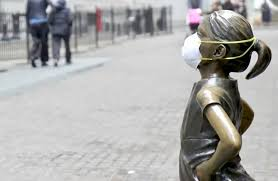

The Matthews Correlation Coefficient (MCC) has a range of -1 to 1, where -1 is a completely bad binary classifier and 1 is a completely valid binary classifier.


<font size="3"> 
$ \bbox[23px,border:1px solid red]
{
 MCC = \displaystyle\frac{{(tp \times tn)}-{(fp \times fn)}}{(tp+fp)(tp+fn)(tn+fp)(tn+fn)}
\qquad   
} $

In [ ]:
def MCC(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    import time   
    
    start_time = time.time()
    
    from sklearn import metrics
    import simple_colors
    
    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)    
    
    
    MCC = ['MCC:']
    
    def compute_metric(model):
        
        from sklearn.metrics import confusion_matrix

        #model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()     
        
        MCC = ((tp*tn)-(fp*fn))/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))** .5)
        MCC = np.round(MCC,decimals=3)
        MCC
        
        return MCC

    for cls in six_classifiers:
        
        results = compute_metric(cls)
        MCC.append(results)
             

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(MCC)
    
    print('Matthews Correlation Coefficient MCC')
        
    ### ---------------------------------------------------
    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
    ### ---------------------------------------------------
        
    if calibration != True:
        print()
    else:   
        print(blue('Models after calibration','bold'))

   

        start_time = time.time()
    
        from sklearn import metrics
        import simple_colors
    
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)    
    
    
        MCC = ['MCC:']
    
        def compute_metric(model):
        
            from sklearn.metrics import confusion_matrix

            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)    
            cm = confusion_matrix(y_test, calibrated.predict(X_test))
            tn, fp, fn, tp = cm.ravel()     
        
            MCC = ((tp*tn)-(fp*fn))/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))** .5)
            MCC = np.round(MCC,decimals=3)
            MCC
        
            return MCC

        for cls in six_classifiers:
        
            results = compute_metric(cls)
            MCC.append(results)
             

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(MCC)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)         
        print(k)
    
       
    print(black('Współczynnik korelacji Matthewsa (MCC) ma zakres od -1 do 1, gdzie -1 oznacza całkowicie zły klasyfikator binarny, a 1 oznacza całkowicie poprawny klasyfikator binarny','italic'))
    

In [ ]:
MCC(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

https://en.wikipedia.org/wiki/Cohen%27s_kappa

## <span style="font-size: 150%;color:#6fa8dc;background:#cfe2f3">Trainsize

In [ ]:
def ks_statistic(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    import scikitplot as skplt
    import time
    start_time = time.time()
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]
        # skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
        skplt.metrics.plot_ks_statistic(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.04, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.04, 'before calibration',color='black', fontsize=10)
### ---------------------------------------------------
    
    if calibration != True:
        print()
    else:   
    
    
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)

        for i in range(9):

            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')

       
            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)         
        
            skplt.metrics.plot_ks_statistic(y_test, calibrated.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
            ax.text(0.5, 1.04, name[i],fontsize=10)    ## podtytuł
            ax.text(0.0, 1.04, 'after calibration',color='red', fontsize=10)    ## podtytuł
    
    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)       

In [ ]:
ks_statistic(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test,calibration=False)

Jak widac na wykresach problemem jest precyzjia klasy 1. Nie pomogła w tym zbilansowanie zbiorów przez oversampling.

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

In [ ]:
def cumulative_gain(six_classifiers,name, X_train, y_train,X_test,y_test):

    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20     
    
    import scikitplot as skplt
    
    plt.figure(figsize=(15,7))
    grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.5)

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)

    for i in range(6):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]

        skplt.metrics.plot_cumulative_gain(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.04, name[i],fontsize=10)    ## podtytuł
        
    plt.show()

In [ ]:
cumulative_gain(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test)

In [ ]:
def lift_curve(six_classifiers,name, X_train, y_train,X_test,y_test):
                
    import scikitplot as skplt
    
    plt.figure(figsize=(15,7))
    grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.5)

    #for cls in six_classifiers:
    #    cls.fit(X_train, y_train)

    for i in range(6):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]

        skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 8.04, name[i],fontsize=12)    ## podtytuł
        
    plt.show()

In [ ]:
lift_curve(clasifier_VAL,name_VAL,X_train, y_train,X_test,y_test)

### Koniec pomiaru czasu 

In [ ]:
print('Time to complete the task')
print('minutes: ',
(time.time() - start_time)/60) ## koniec pomiaru czasu
t = (time.time() - start_time)/60
a,b = df.shape

print('Czas ile minut na jedne rekord: ',t/a)